# Text analyses of all the tweets

In [1]:
import json
import requests
import logging,sys
from getpass import getpass 
import os

## 1. Read in raw data and compile the tweet hashtags and tweets

In [2]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]
datfiles = [f for f in files if 'April' in f]
datfiles
#files in the current directory

['April10_1a',
 'April10_1b',
 'April10_1c',
 'April10_2.json',
 'April10_3a.txt',
 'April10_3b.json',
 'April10_4a',
 'April10_4b',
 'April10_4c',
 'April10_5a',
 'April10_5b',
 'April10_5c',
 'April10_5d',
 'April10_5e',
 'April10_5f',
 'April10_5g',
 'April10_5h',
 'April10_5i',
 'April11.json',
 'April9.json']

In [33]:
texts=[]
tag_list=[]
for fname in datfiles:
    print("Now we are processing data of", fname)
    with open(fname, 'r') as f:
        my_tweets = json.load(f)
    if my_tweets[-1] is None:
        del my_tweets[-1]
    for a_tweet in my_tweets:
        if 'lang' in a_tweet:
            if a_tweet['lang']!='en':  #filtering out all the non-english tweets
                continue
        if 'retweeted_status' in a_tweet: #filtering out retweets
            continue  
        if 'entities' in a_tweet:
            tag_list.append(a_tweet["entities"]["hashtags"])
        if 'extended_tweet' in a_tweet:
            texts.append(a_tweet["extended_tweet"]["full_text"]) #full text of truncated tweets
        elif 'text' in a_tweet:
            texts.append(a_tweet["text"])
        
    print("Now the texts length is", len(texts))

Now we are processing data of April10_1a
Now the texts length is 13489
Now we are processing data of April10_1b
Now the texts length is 25141
Now we are processing data of April10_1c
Now the texts length is 35006
Now we are processing data of April10_2.json
Now the texts length is 46839
Now we are processing data of April10_3a.txt
Now the texts length is 46842
Now we are processing data of April10_3b.json
Now the texts length is 46846
Now we are processing data of April10_4a
Now the texts length is 52535
Now we are processing data of April10_4b
Now the texts length is 59151
Now we are processing data of April10_4c
Now the texts length is 64590
Now we are processing data of April10_5a
Now the texts length is 70634
Now we are processing data of April10_5b
Now the texts length is 77004
Now we are processing data of April10_5c
Now the texts length is 84159
Now we are processing data of April10_5d
Now the texts length is 91634
Now we are processing data of April10_5e
Now the texts length is

This results in 328,223 English tweets

## 2. Analyses of the hashtags

In this section, I am interested in knowing the occurences of all the hashtags in the tweets, and co-occurences of hashtags.

In [42]:
tag_unigrams = []
tag_bigrams = []
tag_trigrams = []

for tags in tag_list:
    if len(tags) is 0:
        continue  
    a_tweet_tags = []
    a_tweet_bigrams=[]
    a_tweet_trigrams=[]
    for idx,tag in enumerate(tags):  # Enumerate returns a tuple: (index, object) for each object in the list
            a_tweet_tags.append(tag["text"].lower())
            for tag2 in tags[(idx+1):]:  # From (idx+1) to end--all later tags
                a_bigram = [tag["text"].lower(), tag2["text"].lower()]   # So they're all lowercase
                a_bigram.sort() 
                a_tweet_bigrams.append(tuple(a_bigram))
            for tag3 in tags[(idx+2):]:
                a_trigram = [tag["text"].lower(), tags[(idx+1)]["text"].lower(), tag3["text"].lower()]
                a_trigram.sort()
                a_tweet_trigrams.append(tuple(a_trigram))
    tag_unigrams.extend(set(a_tweet_tags)) #to make sure that repetitive hashtags in each tweet only appear once
    tag_bigrams.extend(set(a_tweet_bigrams)) 
    tag_trigrams.extend(set(a_tweet_trigrams)) 
    

In [43]:
print(len(tag_unigrams))
print(len(tag_bigrams))
print(len(tag_trigrams))

101525
62612
31328


In [36]:
from collections import Counter

tag_count = Counter(tag_unigrams)
print(tag_count.most_common(20))
print("\n")
tag_bigram_count = Counter(tag_bigrams)
print(tag_bigram_count.most_common(10))
print("\n")
tag_trigram_count = Counter(tag_trigrams)
print(tag_trigram_count.most_common(10))

[('nationalsiblingsday', 39082), ('nationalsiblingday', 21966), ('siblingsday', 1961), ('siblingday', 1067), ('siblings', 1000), ('family', 765), ('tuesdaythoughts', 695), ('sisters', 649), ('equalpayday', 603), ('brothers', 456), ('love', 365), ('zuckerberg', 364), ('sister', 352), ('flyer', 294), ('brochure', 291), ('brother', 280), ('rack', 268), ('onlychild', 243), ('roll', 237), ('throwback', 169)]


[(('nationalsiblingsday', 'tuesdaythoughts'), 618), (('equalpayday', 'nationalsiblingsday'), 538), (('nationalsiblingday', 'nationalsiblingsday'), 290), (('brochure', 'flyer'), 290), (('nationalsiblingsday', 'zuckerberg'), 279), (('flyer', 'rack'), 268), (('brochure', 'rack'), 268), (('equalpayday', 'tuesdaythoughts'), 260), (('family', 'nationalsiblingsday'), 258), (('nationalsiblingsday', 'sisters'), 250)]


[(('brochure', 'flyer', 'rack'), 268), (('equalpayday', 'nationalsiblingsday', 'tuesdaythoughts'), 248), (('flyer', 'rack', 'roll'), 236), (('brochure', 'flyer', 'roll'), 236), 

I wanted to delete all the items that are or contain #nationalsiblingsday, #nationalsiblingday, #siblingsday, and #siblingday, to make a better representation.

In [52]:
exclude_list = ['nationalsiblingsday', 'nationalsiblingday', 'siblingsday', 'siblingday']
tag_unigrams_c = [tag for tag in tag_unigrams if tag not in exclude_list]
tag_count = Counter(tag_unigrams_c)
print(tag_count.most_common(15), "\n")

tag_bigrams_c = tag_bigrams
tag_trigrams_c = tag_trigrams
for excluded in exclude_list:
    tag_bigrams_c = [tagbi for tagbi in tag_bigrams_c if excluded not in tagbi]
    tag_trigrams_c = [tagtri for tagtri in tag_trigrams_c if excluded not in tagtri]
tag_bigram_count = Counter(tag_bigrams_c)
tag_trigram_count = Counter(tag_trigrams_c)
print(tag_bigram_count.most_common(15), "\n")
print(tag_trigram_count.most_common(15))

[('siblings', 1000), ('family', 765), ('tuesdaythoughts', 695), ('sisters', 649), ('equalpayday', 603), ('brothers', 456), ('love', 365), ('zuckerberg', 364), ('sister', 352), ('flyer', 294), ('brochure', 291), ('brother', 280), ('rack', 268), ('onlychild', 243), ('roll', 237)] 

[(('brochure', 'flyer'), 290), (('flyer', 'rack'), 268), (('brochure', 'rack'), 268), (('equalpayday', 'tuesdaythoughts'), 260), (('brochure', 'roll'), 236), (('flyer', 'roll'), 236), (('rack', 'roll'), 236), (('family', 'siblings'), 168), (('equalpayday', 'zuckerberg'), 167), (('americanidol', 'foodasitcom'), 152), (('americanidol', 'marilynmonday'), 148), (('foodasitcom', 'marilynmonday'), 148), (('family', 'love'), 144), (('brother', 'sister'), 142), (('lifecouldbeeasierif', 'tuesdaythoughts'), 126)] 

[(('brochure', 'flyer', 'rack'), 268), (('flyer', 'rack', 'roll'), 236), (('brochure', 'flyer', 'roll'), 236), (('americanidol', 'foodasitcom', 'marilynmonday'), 148), (('equalpayday', 'lifecouldbeeasierif', 

In [50]:
'nationalsiblingsday' in ('fashion', 'nationalsiblingsday', 'tuesdaythoughts')

True

In [60]:
from prettytable import PrettyTable



labels, counts = zip(*tag_count.most_common(15))

pt = PrettyTable()
pt.add_column("Single Hashtag", labels)
pt.add_column("Count", counts)

print(pt.get_html_string()) #print out html version of table, for ease of presentation on github

<table>
    <tr>
        <th>Single Hashtag</th>
        <th>Count</th>
    </tr>
    <tr>
        <td>siblings</td>
        <td>1000</td>
    </tr>
    <tr>
        <td>family</td>
        <td>765</td>
    </tr>
    <tr>
        <td>tuesdaythoughts</td>
        <td>695</td>
    </tr>
    <tr>
        <td>sisters</td>
        <td>649</td>
    </tr>
    <tr>
        <td>equalpayday</td>
        <td>603</td>
    </tr>
    <tr>
        <td>brothers</td>
        <td>456</td>
    </tr>
    <tr>
        <td>love</td>
        <td>365</td>
    </tr>
    <tr>
        <td>zuckerberg</td>
        <td>364</td>
    </tr>
    <tr>
        <td>sister</td>
        <td>352</td>
    </tr>
    <tr>
        <td>flyer</td>
        <td>294</td>
    </tr>
    <tr>
        <td>brochure</td>
        <td>291</td>
    </tr>
    <tr>
        <td>brother</td>
        <td>280</td>
    </tr>
    <tr>
        <td>rack</td>
        <td>268</td>
    </tr>
    <tr>
        <td>onlychild</td>
        <td>243</td>
    </t

In [58]:
from prettytable import PrettyTable



labels, counts = zip(*tag_bigram_count.most_common(15))

pt = PrettyTable()
pt.add_column("Hashtag Bigrams", labels)
pt.add_column("Count", counts)

print(pt.get_html_string()) #print out html version of table, for ease of presentation on github

<table>
    <tr>
        <th>Hashtag Bigrams</th>
        <th>Count</th>
    </tr>
    <tr>
        <td>(&#x27;brochure&#x27;, &#x27;flyer&#x27;)</td>
        <td>290</td>
    </tr>
    <tr>
        <td>(&#x27;flyer&#x27;, &#x27;rack&#x27;)</td>
        <td>268</td>
    </tr>
    <tr>
        <td>(&#x27;brochure&#x27;, &#x27;rack&#x27;)</td>
        <td>268</td>
    </tr>
    <tr>
        <td>(&#x27;equalpayday&#x27;, &#x27;tuesdaythoughts&#x27;)</td>
        <td>260</td>
    </tr>
    <tr>
        <td>(&#x27;brochure&#x27;, &#x27;roll&#x27;)</td>
        <td>236</td>
    </tr>
    <tr>
        <td>(&#x27;flyer&#x27;, &#x27;roll&#x27;)</td>
        <td>236</td>
    </tr>
    <tr>
        <td>(&#x27;rack&#x27;, &#x27;roll&#x27;)</td>
        <td>236</td>
    </tr>
    <tr>
        <td>(&#x27;family&#x27;, &#x27;siblings&#x27;)</td>
        <td>168</td>
    </tr>
    <tr>
        <td>(&#x27;equalpayday&#x27;, &#x27;zuckerberg&#x27;)</td>
        <td>167</td>
    </tr>
    <tr>
        <t

In [59]:
labels, counts = zip(*tag_trigram_count.most_common(15))

pt = PrettyTable()
pt.add_column("Hashtag", labels)
pt.add_column("Count", counts)

print(pt.get_html_string())

<table>
    <tr>
        <th>Hashtag</th>
        <th>Count</th>
    </tr>
    <tr>
        <td>(&#x27;brochure&#x27;, &#x27;flyer&#x27;, &#x27;rack&#x27;)</td>
        <td>268</td>
    </tr>
    <tr>
        <td>(&#x27;flyer&#x27;, &#x27;rack&#x27;, &#x27;roll&#x27;)</td>
        <td>236</td>
    </tr>
    <tr>
        <td>(&#x27;brochure&#x27;, &#x27;flyer&#x27;, &#x27;roll&#x27;)</td>
        <td>236</td>
    </tr>
    <tr>
        <td>(&#x27;americanidol&#x27;, &#x27;foodasitcom&#x27;, &#x27;marilynmonday&#x27;)</td>
        <td>148</td>
    </tr>
    <tr>
        <td>(&#x27;equalpayday&#x27;, &#x27;lifecouldbeeasierif&#x27;, &#x27;tuesdaythoughts&#x27;)</td>
        <td>97</td>
    </tr>
    <tr>
        <td>(&#x27;cbx_bloomingdays&#x27;, &#x27;felizmartes&#x27;, &#x27;temblor&#x27;)</td>
        <td>97</td>
    </tr>
    <tr>
        <td>(&#x27;cbx_bloomingdays&#x27;, &#x27;mondaymotivation&#x27;, &#x27;temblor&#x27;)</td>
        <td>81</td>
    </tr>
    <tr>
        <td>(&#x27

In [63]:
[text for text in texts if '#equalpayday' in text.lower()][0:10]

['NP: #GoodMorningBeautiful @steveholy \n\non the #GoodMorningNigeriaShow with @MahoganySilver_ \n\n#MedicalTuesday  #BreakfastwithMahogany #SiblingDay #EqualPayDay \n\n Listen online via https://t.co/p194KpzI3L https://t.co/kamVqS2ig2',
 'NP: #IJustDiedInYourarms @The_CuttingCrew \n\non the #GoodMorningNigeriaShow with @MahoganySilver_ \n\n#MedicalTuesday  #BreakfastwithMahogany #SiblingDay #EqualPayDay \n\n Listen online via https://t.co/p194KpzI3L https://t.co/KvkdDc5LEL',
 'NP: #LoveMyLife @robbiewilliams \n\non the #GoodMorningNigeriaShow with @MahoganySilver_ \n\n#MedicalTuesday  #BreakfastwithMahogany #SiblingDay #EqualPayDay \n\n Listen online via https://t.co/p194KpzI3L https://t.co/uaCJBEmT3Q',
 'NP: #CircleOfLife @TheLionKing \n\non the #GoodMorningNigeriaShow with @MahoganySilver_ \n\n#MedicalTuesday  #BreakfastwithMahogany #SiblingDay #EqualPayDay \n\n Listen online via https://t.co/p194KpzI3L https://t.co/V0ARb2HMDL',
 'NP: #sunshine  by Monday Morning \n\non the #GoodMor

In [69]:
[text for text in texts if '#onlychild' in text.lower()][0:10]

['Happy me day, I unfortunately never got a sibling as my dad said I was the  best contraceptive as I put my parents off 100% of having another child 🤷🏼\u200d♀️ #NationalSiblingsDay #onlychildproblems',
 'Shout out to all the Only Childs on #NationalSiblingsDay 🙌🏻\nRemember in French it is said “Je suis fille unique”, it’s good to be unique. It’s not our fault that our parents realised they couldn’t improve on perfection 🤷🏻\u200d♀️ #onlychild',
 'Hey Twitter Good Tuesday morning 🐣🐰 Happy national sibling day 👪to everyone who has siblings sincerely from #onlychild',
 'I can’t celebrate #NationalSiblingsDay #onlychildproblems',
 'Happy #NationalSiblingsDay ohhhh wait... never mind. #OnlyChild',
 'Happy siblings day to my ride or die imaginary sister! Just kidding \U0001f92a #onlychildprobs',
 "I don't need to celebrate #NationalSiblingsDay since my folks got it right the first time. #OnlyChild 🤣🤣 https://t.co/zWj0moD6pU",
 'Wish I had one #NationalSiblingsDay #onlychild #boo https://t.co

## 3. Analyses of the tweet content - Ngrams

I am using the nltk package for analyses on the tweet content (i.e., text)

In [79]:
#!conda install -y -c anaconda nltk
import nltk
#nltk.download("punkt")
#nltk.download("stopwords")
from nltk.collocations import ngrams
from nltk.corpus import stopwords
import urllib
import string

In [116]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tokens = [tknzr.tokenize(text) for text in texts]
tokens[0:2]

[['Shout',
  'out',
  'to',
  'all',
  'my',
  'brothers',
  '.',
  'Gang',
  'gang',
  'for',
  'life',
  '.',
  '#SiblingsDay',
  'https://t.co/ztnmnF2LGs'],
 ['@WGRZ',
  'It',
  'is',
  'so',
  'rare',
  'that',
  'we',
  '’',
  're',
  'all',
  'together',
  'and',
  'yes',
  ',',
  'we',
  '’',
  've',
  'established',
  'that',
  'I',
  '’',
  'm',
  'the',
  'tallest',
  '.',
  '#NationalSiblingsDay',
  '#BeOn2',
  'https://t.co/aC9nXcvmgj']]

In [93]:
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("english")

In [119]:
#clean the token list
clean_token_list = []
stem_word_lookup = {}

for tweet in tokens:
    clean_tweet = []
    for word in tweet:
        if word.startswith("htt") or word.startswith("@") or word.startswith("#") \
                            or word == "RT" \
                            or word in string.punctuation or word == "’" \
                            or word.lower() in stopwords.words('english'):   #this punctuation is not in the string punct list
            continue # Skip this one!
        else:
            stem = ss.stem(word)
            clean_tweet.append(stem)
            if not stem in stem_word_lookup.keys():
                stem_word_lookup[stem] = []
            if not word in stem_word_lookup[stem]:
                stem_word_lookup[stem].append(word)
    clean_token_list.append(clean_tweet)

In [162]:
clean_token_list[-1]

['easi',
 'refuge',
 'girl',
 'refuge',
 'tougher',
 'often',
 'stay',
 'home',
 'help',
 'housework',
 'take',
 'care',
 'younger',
 'sibl',
 'donat',
 'support',
 'life',
 'honor',
 'intern',
 'children',
 'day',
 'april',
 '23rd']

In [132]:
#combining all the tokens with sentinel indicating different tweets
clean_token_join=[]
for tokens in clean_token_list:
    clean_token_join.append(' '.join(tokens))

# Here's our sentinel word.
sentinel = 'LLLLLLLLL'
# For convenience, with spaces.
spaced_sentinel = ' ' + sentinel + ' '
combinedTokens=spaced_sentinel.join(clean_token_join).split()
print(clean_token_join[0:10])
combinedTokens[0:500]

['shout brother gang gang life', 'rare togeth yes establish tallest', "know sibl grow defend 😂 never thought i'd see day", 'would dead ass kill idgaf idc hit hit sibl mine done', 'happi bradi bunch', "good morn today we'r celebr sibl day join us studio", 'need somewhat appreci know …', 'happi nation sibl day love 3 brother sister', 'appar sibl day today thought recognis sibl famili run busi sell handmad market like long-tim fave sweet sista happi sibl day sibling-run busi', 'happi sister mexico 2008']


['shout',
 'brother',
 'gang',
 'gang',
 'life',
 'LLLLLLLLL',
 'rare',
 'togeth',
 'yes',
 'establish',
 'tallest',
 'LLLLLLLLL',
 'know',
 'sibl',
 'grow',
 'defend',
 '😂',
 'never',
 'thought',
 "i'd",
 'see',
 'day',
 'LLLLLLLLL',
 'would',
 'dead',
 'ass',
 'kill',
 'idgaf',
 'idc',
 'hit',
 'hit',
 'sibl',
 'mine',
 'done',
 'LLLLLLLLL',
 'happi',
 'bradi',
 'bunch',
 'LLLLLLLLL',
 'good',
 'morn',
 'today',
 "we'r",
 'celebr',
 'sibl',
 'day',
 'join',
 'us',
 'studio',
 'LLLLLLLLL',
 'need',
 'somewhat',
 'appreci',
 'know',
 '…',
 'LLLLLLLLL',
 'happi',
 'nation',
 'sibl',
 'day',
 'love',
 '3',
 'brother',
 'sister',
 'LLLLLLLLL',
 'appar',
 'sibl',
 'day',
 'today',
 'thought',
 'recognis',
 'sibl',
 'famili',
 'run',
 'busi',
 'sell',
 'handmad',
 'market',
 'like',
 'long-tim',
 'fave',
 'sweet',
 'sista',
 'happi',
 'sibl',
 'day',
 'sibling-run',
 'busi',
 'LLLLLLLLL',
 'happi',
 'sister',
 'mexico',
 '2008',
 'LLLLLLLLL',
 'day',
 'someon',
 'come',
 'sibl',
 'day',
 'c

Unigrams first.

In [134]:
unigrams = [n for n in ngrams(combinedTokens,1) if sentinel not in n]
print(unigrams[0:20])
unigram_frequency = Counter([" ".join(gram) for gram in unigrams])

[('shout',), ('brother',), ('gang',), ('gang',), ('life',), ('rare',), ('togeth',), ('yes',), ('establish',), ('tallest',), ('know',), ('sibl',), ('grow',), ('defend',), ('😂',), ('never',), ('thought',), ("i'd",), ('see',), ('day',)]


In [135]:
unigram_frequency.most_common(50)

[('sibl', 66477),
 ('day', 57643),
 ('happi', 52098),
 ('nation', 37109),
 ('love', 22247),
 ('️', 19914),
 ('brother', 19432),
 ('sister', 19035),
 ('❤', 15547),
 ('…', 12621),
 ('...', 9268),
 ('best', 7856),
 ('one', 7523),
 ('like', 6262),
 ('😂', 5729),
 ('post', 5264),
 ('know', 5108),
 ('today', 4777),
 ('littl', 4454),
 ('thank', 4329),
 ('💕', 4301),
 ('two', 4196),
 ('alway', 4066),
 ('\u200d', 4001),
 ('famili', 3944),
 ('much', 3812),
 ('get', 3766),
 ('pictur', 3721),
 ('us', 3643),
 ('big', 3545),
 ('friend', 3514),
 ('year', 3509),
 ('time', 3397),
 ('favorit', 3282),
 ('look', 3139),
 ('life', 3050),
 ('sib', 3050),
 ('pic', 2988),
 ('bro', 2944),
 ('make', 2944),
 ('celebr', 2931),
 ('miss', 2896),
 ('guy', 2894),
 ('even', 2713),
 ('sis', 2682),
 ('see', 2643),
 ('peopl', 2639),
 ('child', 2605),
 ('ever', 2579),
 ('😘', 2504)]

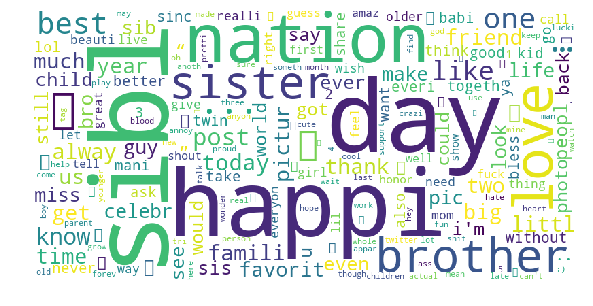

In [152]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(unigram_frequency)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Bigrams

In [153]:
bigrams = [n for n in ngrams(combinedTokens,2) if sentinel not in n]
print(bigrams[0:20])
bigram_frequency = Counter([" ".join(gram) for gram in bigrams])

[('shout', 'brother'), ('brother', 'gang'), ('gang', 'gang'), ('gang', 'life'), ('rare', 'togeth'), ('togeth', 'yes'), ('yes', 'establish'), ('establish', 'tallest'), ('know', 'sibl'), ('sibl', 'grow'), ('grow', 'defend'), ('defend', '😂'), ('😂', 'never'), ('never', 'thought'), ('thought', "i'd"), ("i'd", 'see'), ('see', 'day'), ('would', 'dead'), ('dead', 'ass'), ('ass', 'kill')]


In [154]:
bigram_frequency.most_common(50)

[('sibl day', 48697),
 ('nation sibl', 35061),
 ('happi nation', 20268),
 ('❤ ️', 13514),
 ('happi sibl', 9810),
 ('️ ❤', 3095),
 ('brother sister', 2946),
 ('\u200d ♀', 2258),
 ('♀ ️', 2257),
 ('best friend', 2208),
 ('sib day', 2182),
 ('day love', 1809),
 ('😂 😂', 1603),
 ('day best', 1401),
 ('day ❤', 1265),
 ('♥ ️', 1258),
 ('day brother', 1254),
 ('day ...', 1193),
 ('littl brother', 1083),
 ('. .', 1057),
 ('love guy', 1024),
 ('nation sib', 1005),
 ('love much', 966),
 ('day sister', 948),
 ('big brother', 936),
 ('love ya', 925),
 ('happi sib', 909),
 ('littl sister', 882),
 ('happi best', 785),
 ('today nation', 783),
 ('best brother', 759),
 ('day one', 754),
 ('👯 \u200d', 754),
 ('best sister', 749),
 ('even though', 746),
 ('day sibl', 745),
 ('day two', 734),
 ('big sister', 709),
 ('sister love', 681),
 ('day post', 680),
 ('love sister', 679),
 ('\u200d ♂', 671),
 ('♂ ️', 671),
 ('love brother', 654),
 ('🏻 \u200d', 633),
 ('love ❤', 632),
 ('love u', 619),
 ('💕 💕', 618),

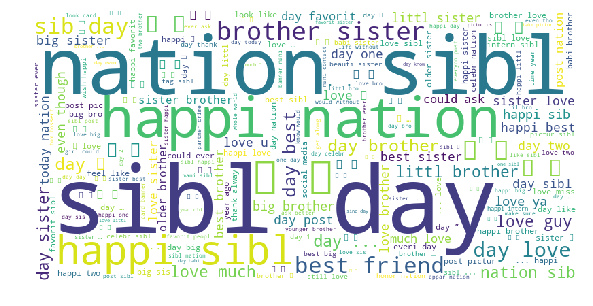

In [155]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(bigram_frequency)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Trigrams

In [156]:
trigrams = [n for n in ngrams(combinedTokens,3) if sentinel not in n]
print(trigrams[0:20])
trigram_frequency = Counter([" ".join(gram) for gram in trigrams])

[('shout', 'brother', 'gang'), ('brother', 'gang', 'gang'), ('gang', 'gang', 'life'), ('rare', 'togeth', 'yes'), ('togeth', 'yes', 'establish'), ('yes', 'establish', 'tallest'), ('know', 'sibl', 'grow'), ('sibl', 'grow', 'defend'), ('grow', 'defend', '😂'), ('defend', '😂', 'never'), ('😂', 'never', 'thought'), ('never', 'thought', "i'd"), ('thought', "i'd", 'see'), ("i'd", 'see', 'day'), ('would', 'dead', 'ass'), ('dead', 'ass', 'kill'), ('ass', 'kill', 'idgaf'), ('kill', 'idgaf', 'idc'), ('idgaf', 'idc', 'hit'), ('idc', 'hit', 'hit')]


In [157]:
trigram_frequency.most_common(50)

[('nation sibl day', 34933),
 ('happi nation sibl', 19460),
 ('happi sibl day', 9493),
 ('️ ❤ ️', 3092),
 ('❤ ️ ❤', 2961),
 ('\u200d ♀ ️', 2255),
 ('sibl day love', 1663),
 ('sibl day best', 1300),
 ('sibl day brother', 1193),
 ('sibl day ❤', 1160),
 ('day ❤ ️', 1121),
 ('sibl day ...', 1073),
 ('nation sib day', 1000),
 ('sibl day sister', 886),
 ('happi sib day', 878),
 ('today nation sibl', 766),
 ('. . .', 699),
 ('sibl day two', 688),
 ('👯 \u200d ♀', 680),
 ('\u200d ♂ ️', 671),
 ('happi nation sib', 664),
 ('sibl day post', 617),
 ('sibl day sibl', 589),
 ('sibl day favorit', 571),
 ('post nation sibl', 565),
 ('love ❤ ️', 546),
 ('😂 😂 😂', 527),
 ('sibl day one', 470),
 ('🏻 \u200d ♀', 453),
 ('sibl day littl', 450),
 ('intern sibl day', 419),
 ('happi ❤ ️', 406),
 ('🏼 \u200d ♀', 400),
 ('❤ ️ love', 390),
 ('sibl day …', 369),
 ('🏽 \u200d ♀', 345),
 ('sister ❤ ️', 342),
 ('sibl day 💕', 341),
 ('celebr nation sibl', 319),
 ('sibl day ”', 309),
 ('sibl day big', 308),
 ('sibl day lik

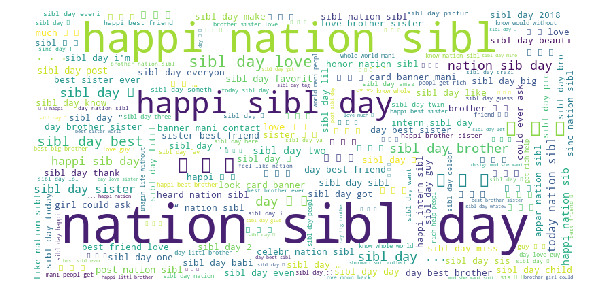

In [161]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(trigram_frequency)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 4. Analyses of the tweet content - LDA Topic Modeling

Then I perform LDA topic modeling to the clean token list to figure out common topics.
I loop through 1 to 20 topics to obtain the model perplexity (lower is better) and the topic coherence (higher is better) of each topic model with certain number of topics predefined.

In [163]:
#!conda install -y gensim 
from gensim import corpora
vocab = corpora.Dictionary(clean_token_list)
corpus = [vocab.doc2bow(tweet) for tweet in clean_token_list]
corpus[0:10]

[[(0, 1), (1, 2), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1)],
 [(16, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1)],
 [(28, 1), (29, 1), (30, 1)],
 [(9, 1),
  (16, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1)],
 [(13, 1), (39, 1), (40, 1), (41, 1), (42, 1)],
 [(0, 1), (9, 1), (16, 1), (30, 1), (43, 1), (44, 1), (45, 1), (46, 1)],
 [(9, 2),
  (16, 3),
  (17, 1),
  (30, 1),
  (36, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(30, 1), (46, 1), (61, 1), (62, 1)]]

In [168]:
from gensim.models import ldamodel
from gensim.models import CoherenceModel

In [169]:
tweet_lda = ldamodel.LdaModel(corpus, num_topics=5, id2word = vocab, passes = 20)

In [175]:
tweet_lda.log_perplexity(corpus)

-6.947634661744523

In [177]:
CoherenceModel(model=tweet_lda, texts=clean_token_list,
                                        dictionary=vocab, coherence='c_v').get_coherence()

0.40660693630952

In [ ]:
complexity = []
coherence = []
for i in range(1,21):
    tweet_lda = ldamodel.LdaModel(corpus, num_topics=i, id2word = vocab, passes = 20)
    complexity.append(tweet_lda.log_perplexity(corpus))
    coherence.append(CoherenceModel(model=tweet_lda, texts=clean_token_list,
                                        dictionary=vocab, coherence='c_v').get_coherence())

## 5. Analyses of the tweet content - Sentiment Analysis

In [174]:
len(corpus)

132469

In [173]:
clean_token_list[0:50]

[['shout', 'brother', 'gang', 'gang', 'life'],
 ['rare', 'togeth', 'yes', 'establish', 'tallest'],
 ['know',
  'sibl',
  'grow',
  'defend',
  '😂',
  'never',
  'thought',
  "i'd",
  'see',
  'day'],
 ['would',
  'dead',
  'ass',
  'kill',
  'idgaf',
  'idc',
  'hit',
  'hit',
  'sibl',
  'mine',
  'done'],
 ['happi', 'bradi', 'bunch'],
 ['good',
  'morn',
  'today',
  "we'r",
  'celebr',
  'sibl',
  'day',
  'join',
  'us',
  'studio'],
 ['need', 'somewhat', 'appreci', 'know', '…'],
 ['happi', 'nation', 'sibl', 'day', 'love', '3', 'brother', 'sister'],
 ['appar',
  'sibl',
  'day',
  'today',
  'thought',
  'recognis',
  'sibl',
  'famili',
  'run',
  'busi',
  'sell',
  'handmad',
  'market',
  'like',
  'long-tim',
  'fave',
  'sweet',
  'sista',
  'happi',
  'sibl',
  'day',
  'sibling-run',
  'busi'],
 ['happi', 'sister', 'mexico', '2008'],
 ['day', 'someon', 'come', 'sibl', 'day', 'catch', 'mf', 'case'],
 ['happi', 'jane', 'blanch', '♥', '️'],
 ['blast', 'past', 'spring', '1985']